In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('social-distancing-student')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 5

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

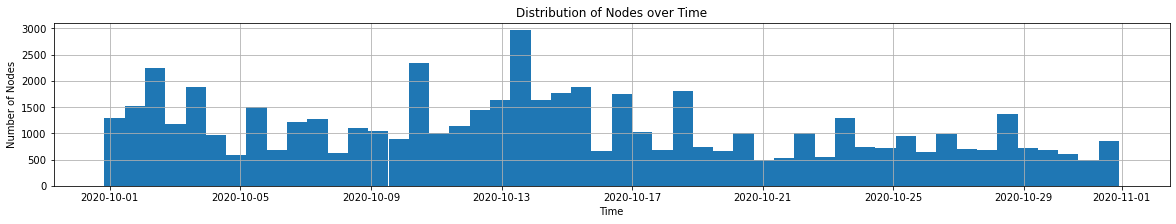

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 93433
Number of Edges: 3710183
Density: 0.0008500204765102186


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 79.41911316130275
Median Degree: 4.0


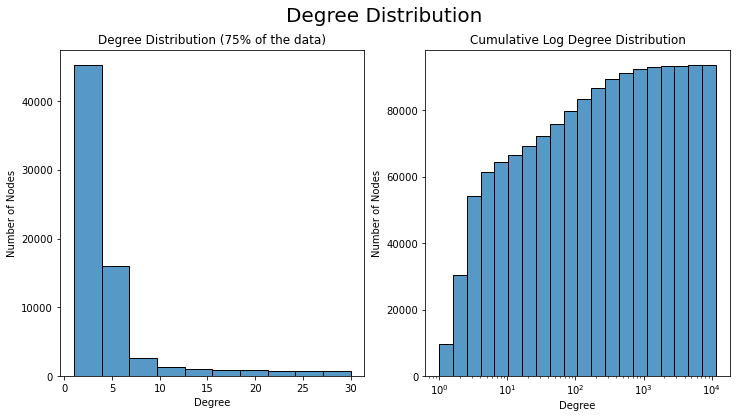

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.297
Diameter: 15


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,92828.000000,92828.000000,9.282800e+04,92828.000000,82458.000000
mean,0.000861,0.000027,9.327505e-04,0.000011,0.338164
std,0.003063,0.001088,3.146855e-03,0.000031,0.352957
min,0.000011,0.000000,2.292513e-21,0.000002,0.000000
25%,0.000022,0.000000,4.537200e-06,0.000002,0.000000
50%,0.000043,0.000000,3.081323e-05,0.000004,0.234477
75%,0.000345,0.000005,3.225603e-04,0.000008,0.499552
max,0.123940,0.198059,6.207933e-02,0.002366,1.000000


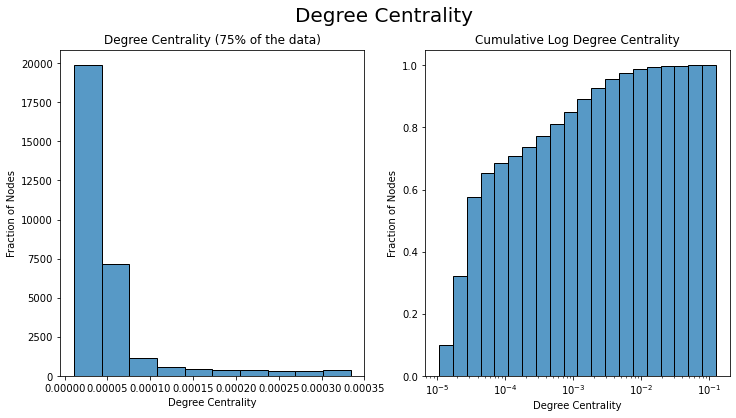

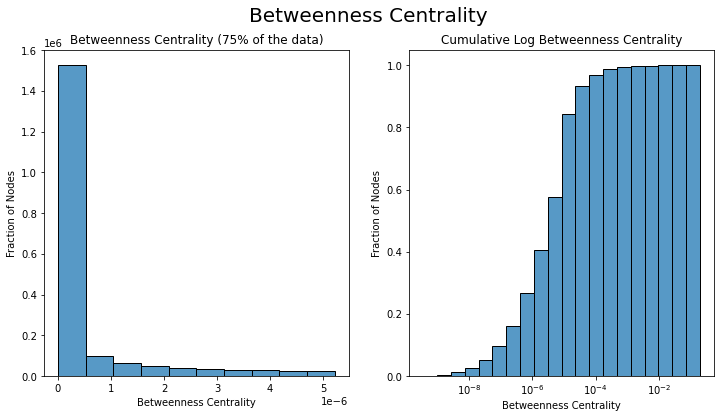

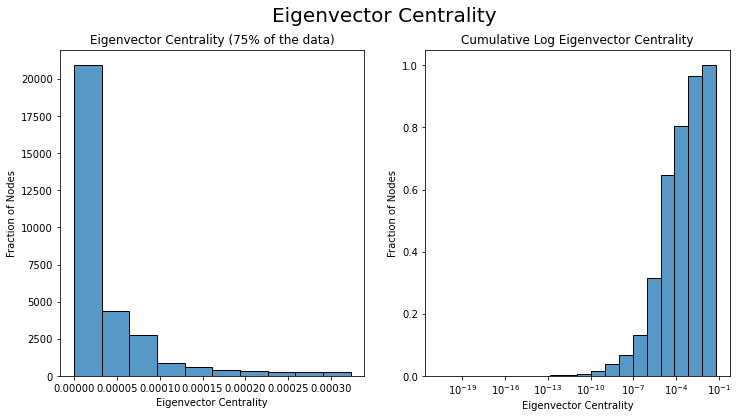

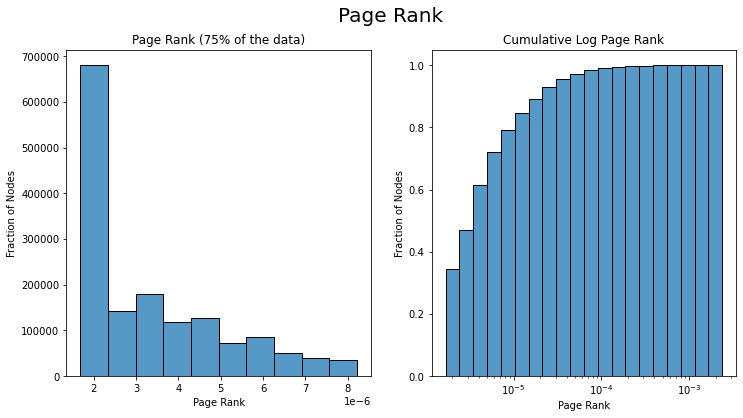

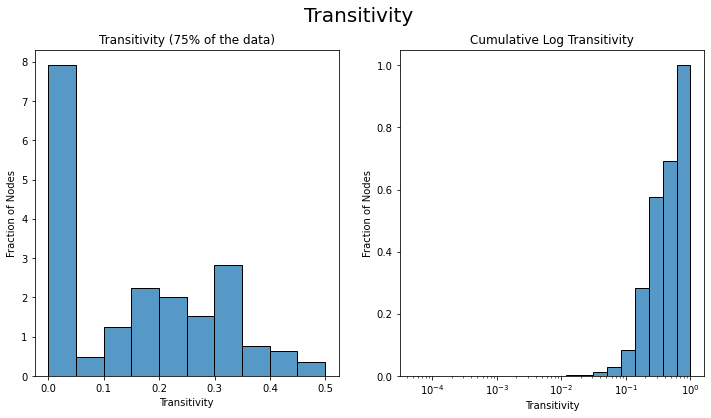

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.123940,NOS,0.198059,Maryfloor для России وإيران وسوريا,0.062079,Thierry Baudet,0.002366,Mark Rutte,1.0,RT @UitInTiel: Vandaag of in het weekend boods...
1,0.119286,Mark Rutte,0.186542,Niels Simons,0.056700,Wierd Duk,0.002314,NOS,1.0,"RT @Cryptopixels: Blijf thuis, mondkapje op, g..."
2,0.083069,RIVM,0.109384,Hans Zuidinga #Levenskunstenaar,0.053949,NOS,0.001378,Maurice de Hond,1.0,"Europa zucht, steunt en mort tijdens tweede co..."
3,0.082627,Matthijs Pontier 💜🏴‍☠️,0.091821,🏛Gaia of the Universe🏛,0.053103,Ebru Umar #1,0.001359,RIVM,1.0,@oogstgroningen De Herestraat is veel te smal ...
4,0.080321,NU.nl,0.072585,Y,0.050931,Maurice de Hond,0.001283,Marc Van Ranst,1.0,"@moeva18 Echt niet, hou maar gewoon afstand, j..."
5,0.076573,de Volkskrant,0.046374,Raisa Blommestijn,0.050725,Sietske Bergsma,0.001254,NU.nl,1.0,RT @Nieuwsuur: Op zeker 342 van de 648 Nederla...
6,0.076012,RTL Nieuws,0.041186,Wim Tuijl,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001205,Hugo de Jonge,1.0,RT @rob_televisie: Luid zingen en schermutseli...
7,0.075280,Thierry Baudet,0.037057,NOS,0.050463,Mark Rutte,0.001155,RTL Nieuws,1.0,RT @AsbaiBadr: Strengere maatregelen= staat vo...
8,0.073739,Wierd Duk,0.025933,Jessica,0.050386,Martin Bos,0.001142,De Telegraaf,1.0,@marcelbar8 Situatie in Duitsland is onvergeli...
9,0.070701,Maurice de Hond,0.020467,Mark Rutte,0.048908,Jan Dijkgraaf,0.001060,Tim Hofman,1.0,@GuillaumeVdS Had iedereen zich aan de regels ...


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 245
Size of the largest component: 92828


Text(0.5, 1.0, 'Connected Components')

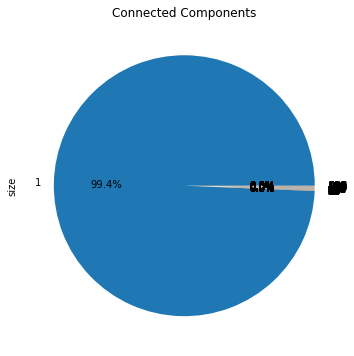

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
User,User,34919,207.401501,69.0
Hashtag,Hashtag,2341,5.259718,1.0
Tweet,Tweet,56173,2.951596,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

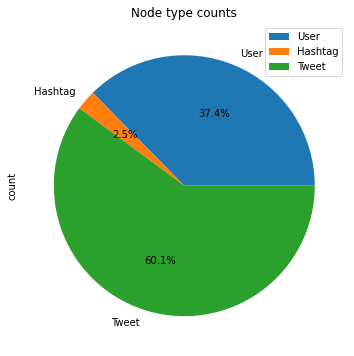

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

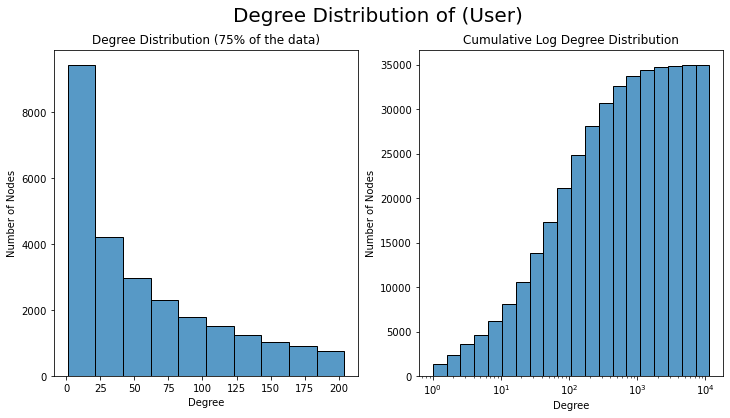

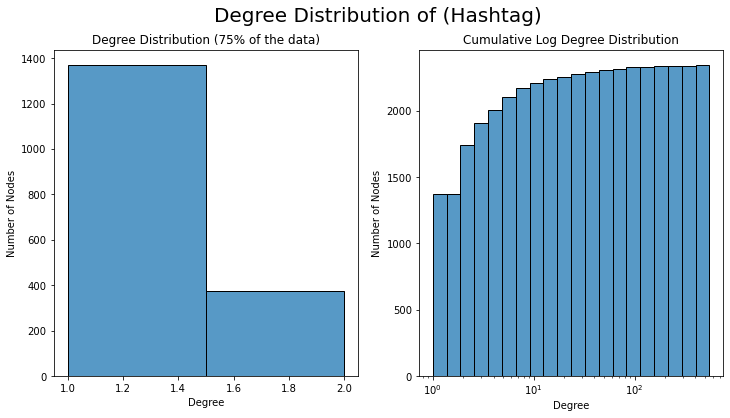

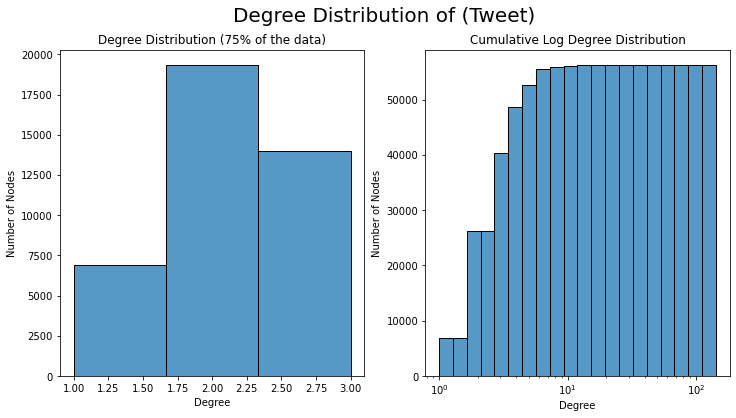

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


Top 10 Degree Nodes of Type (Hashtag)


,value,label
0,552,anderhalvemeter
1,413,coronamaatregelen
2,389,mondkapjes
3,340,mondkapje
4,279,coroNEE
5,223,coronavirus
6,208,Covid19
7,193,anderhalvemeterdictatuur
8,178,corona
9,150,Corona


Top 10 Degree Nodes of Type (Tweet)


,value,label
0,143,"@vanbinnenblauw @lisette1100 Hoi, het is belan..."
1,59,"Volgens collega Wilders is de 1,5 meter-regel ..."
2,34,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA..."
3,29,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...
4,28,Houden ons aan de regels zoals deze vandaag ge...
5,22,"""de coronamaatregelen zijn strikt nageleefd. [..."
6,21,Draag een mondkapje in publiek toegankelijke b...
7,21,RedTeam luidt alarmbellen: ’Leerlingen voortge...
8,16,"Mijn oom heeft corona en is besmettelijk, maar..."
9,16,"@peter_persyn @De7deDag Beste, bedankt voor de..."


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 7


,type,count
TWEETED,TWEETED,56173
REPLIES_TO_USER,REPLIES_TO_USER,21769
REPLIES_TO_TWEET,REPLIES_TO_TWEET,2148
QUOTES_TWEET,QUOTES_TWEET,441
MENTIONS_USER,MENTIONS_USER,70367
MENTIONS_HASHTAG,MENTIONS_HASHTAG,12313
FOLLOWS,FOLLOWS,3546972


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

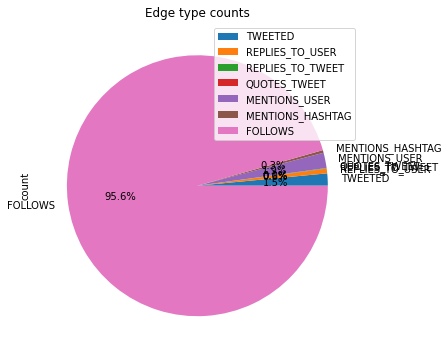

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.123940,NOS,0.198059,Maryfloor для России وإيران وسوريا,0.062079,Thierry Baudet,0.002366,Mark Rutte,1.0,Hazed$
1,0.119286,Mark Rutte,0.186542,Niels Simons,0.056700,Wierd Duk,0.002314,NOS,1.0,a rat 🐀
2,0.083069,RIVM,0.109384,Hans Zuidinga #Levenskunstenaar,0.053949,NOS,0.001378,Maurice de Hond,1.0,Bernhard
3,0.082627,Matthijs Pontier 💜🏴‍☠️,0.091821,🏛Gaia of the Universe🏛,0.053103,Ebru Umar #1,0.001359,RIVM,1.0,Yara Vanherle
4,0.080321,NU.nl,0.072585,Y,0.050931,Maurice de Hond,0.001283,Marc Van Ranst,1.0,Die mit dem Koala tanzt💃(🦠📱)
5,0.076573,de Volkskrant,0.046374,Raisa Blommestijn,0.050725,Sietske Bergsma,0.001254,NU.nl,1.0,Dorpshuis de Begine Hemelum
6,0.076012,RTL Nieuws,0.041186,Wim Tuijl,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001205,Hugo de Jonge,1.0,tayyiba_e
7,0.075280,Thierry Baudet,0.037057,NOS,0.050463,Mark Rutte,0.001155,RTL Nieuws,1.0,Joe Biden
8,0.073739,Wierd Duk,0.025933,Jessica,0.050386,Martin Bos,0.001142,De Telegraaf,1.0,Luke
9,0.070701,Maurice de Hond,0.020467,Mark Rutte,0.048908,Jan Dijkgraaf,0.001060,Tim Hofman,1.0,Laura Roels


Top 10 Nodes by Statistic for Hashtag


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.005947,anderhalvemeter,0.002363,blijfthuis,0.000021,anderhalvemeter,0.000534,anderhalvemeter,1.000000,Ikhebeenmondkapje
1,0.004449,coronamaatregelen,0.000823,coronamaatregelen,0.000017,mondkapjes,0.000389,coronamaatregelen,0.333333,hoekvanholland
2,0.004191,mondkapjes,0.000693,anderhalvemeter,0.000015,Covid19,0.000328,mondkapjes,0.166667,deanderhalvemetershow
3,0.003663,mondkapje,0.000449,mondkapje,0.000015,coronavirus,0.000324,mondkapje,0.100000,leerlingen
4,0.003006,coroNEE,0.000334,coroNEE,0.000013,coronamaatregelen,0.000207,coroNEE,0.047619,CoronaApp
5,0.002402,coronavirus,0.000237,mondkapjes,0.000011,stemmingmakerij,0.000198,corona,0.022222,Covid1984
6,0.002241,Covid19,0.000220,corona,0.000006,BOA,0.000193,coronavirus,0.001587,HetkanallemaalinTwente
7,0.002079,anderhalvemeterdictatuur,0.000153,houdafstand,0.000006,mondkapje,0.000159,Corona,0.001587,VermijdDrukte
8,0.001918,corona,0.000144,anderhalvemeterdictatuur,0.000006,Sneek,0.000157,Covid19,0.001347,freethepeople
9,0.001616,Corona,0.000135,persconferentie,0.000006,Alcoholverbod,0.000150,blijfthuis,0.001282,HoudAfstand


Top 10 Nodes by Statistic for Tweet


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001541,"@vanbinnenblauw @lisette1100 Hoi, het is belan...",0.000474,RT @SLECHTVOLK: Vandaag in #Sneek... \nHeb hel...,0.000479,RT @Peetlief: @FlavioPasquino @hugodejonge @ri...,0.000098,"@vanbinnenblauw @lisette1100 Hoi, het is belan...",1.0,RT @PartijvdDieren: 🍻 Horeca: 3% van de besmet...
1,0.000636,"Volgens collega Wilders is de 1,5 meter-regel ...",0.000174,RT @johnkurf: Alleensamen #coronamaatregelen ...,0.000476,@FlavioPasquino @hugodejonge @rivm @MinPres @m...,0.000050,"Volgens collega Wilders is de 1,5 meter-regel ...",1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
2,0.000366,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA...",0.000165,Alleensamen #coronamaatregelen #CodeRood #and...,0.000431,@hugodejonge @MinPres @thierrybaudet @geertwil...,0.000031,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA...",1.0,"RT @dijkhoff: HOUD 1,5 METER AFSTAND. WAS JE H..."
3,0.000312,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...,0.000129,RT @WakkerGeluid: Net meerdere winkels geweest...,0.000398,@BestNr7 @NPO1 @NOS @MinPres @rivm @ZEMBLA @vo...,0.000024,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...,1.0,@RTLnieuws Respect voor de werkers op de werkv...
4,0.000302,Houden ons aan de regels zoals deze vandaag ge...,0.000129,RT @ProjobJobs: Met spoed op zoek naar toezich...,0.000396,@harry59degroot @FlavioPasquino @GemkeConny @r...,0.000023,Houden ons aan de regels zoals deze vandaag ge...,1.0,RT @wouterkeller: 1/ Prof. Helsloot (BNR):\n\n...
5,0.000237,"""de coronamaatregelen zijn strikt nageleefd. [...",0.000110,RT @GerbenKoppelma1: #coronamaatregelen #blijf...,0.000396,@fritsander @FlavioPasquino @GemkeConny @rivm ...,0.000021,#Schilderworkshop Joke #Krul za. 21 &amp; 28 n...,1.0,RT @mauricedehond: ”Onze maatregelen (handen s...
6,0.000226,RedTeam luidt alarmbellen: ’Leerlingen voortge...,0.000099,"RT @spill2012: Aub @telegraaf. Hier de ""lockdo...",0.000395,@harry59degroot @FlavioPasquino @GemkeConny @r...,0.000021,#coronamaatregelen #blijfthuis #amsterdam #rot...,1.0,@evamariacurlew @Miesli2 Is het ook niet. En w...
7,0.000226,Draag een mondkapje in publiek toegankelijke b...,0.000097,RT @httpchanie: Het is te gek voor woorden dit...,0.000395,@fritsander @FlavioPasquino @GemkeConny @rivm ...,0.000021,RT @rayklaassen: ANDERHALVE METER SESSIES\n\nB...,1.0,RT @RubenHeezen: Aanpassing protocol 'Samen ve...
8,0.000172,"@peter_persyn @De7deDag Beste, bedankt voor de...",0.000096,"RT @3Groter: De anderhalve meter blijft, ook n...",0.000321,RT @BobVeritas: @hommel_b @mariannezw 🤣 Colleg...,0.000021,1.5 met vn elkaar...vandaag met Steam @j.marte...,1.0,"@DerkMoor Ook al had je geen nieuws, los van h..."
9,0.000172,"Mijn oom heeft corona en is besmettelijk, maar...",0.000095,@thierrybaudet @WybrenvanHaga De #vrijheid om ...,0.000318,@Peetlief @DeRedacteur_ @MinPres @hugodejonge ...,0.000020,#BlijfGezond #BlijfBewegen #HoudtAfstand #Weer...,1.0,@Jet9865 Dat stukje heb ik gemist \nMaar waar ...


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.4439807620914561
Number of communities: 479


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

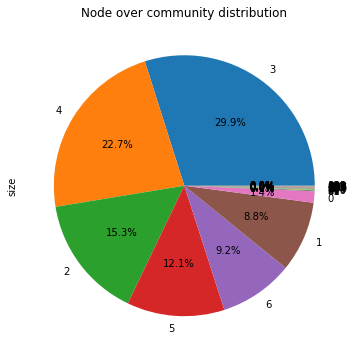

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.004406,Looopings,0.000338,Victor Hopman,0.002943,Sanne van Galen,0.000257,Victor Hopman,1.0,Geen idee wat ze bij entree van de @Efteling a...
1,0.003200,Sanne van Galen,0.000322,ᴮᴱNikita⁷ maskertje op,0.002237,Nick,0.000103,Looopings,1.0,RT @telegraaf: Pretparken zijn als zogeheten ’...
2,0.002790,Kleine Boodschap,0.000258,Looopings,0.001542,Marc,0.000070,M⁷☆,1.0,RT @KevinWeijden: Dat wordt gezellig. Komende ...
3,0.002402,Maxim De Donder,0.000192,♡𝑺𝒖𝒅𝒆 𝒁𝒂𝒏𝒂🐺⁷/ BLM ACAB FREE🇵🇸,0.001429,Looopings,0.000066,Team Looopings,1.0,@HesselB_98 Ik zou vooral de schuld geven aan ...
4,0.002176,LeroyMijns 🥳,0.000156,Tim Hinssen,0.001155,Sergio Harinck,0.000061,ThemeTalk,1.0,"@EftelSteffel Ook, maar wij hebben genoeg ‘vol..."
5,0.002079,Victor Hopman,0.000133,:) JUNE ₁₂₇ ↔ 💕 LAYDAY,0.001111,Max,0.000054,ᴮᴱNikita⁷ maskertje op,1.0,RT @KevinWeijden: Dat wordt gezellig. Komende ...
6,0.002079,ThemeTalk,0.000121,M⁷☆,0.001041,Daan kouwie ® ©,0.000049,🎃✨EftelSteffel✨🎃,1.0,"@Falkenhage Ergens hoop ik van wel, maar ik de..."
7,0.001939,Chelsey,0.000105,ThemeTalk,0.000938,Jaap van Wijk,0.000047,Kleine Boodschap,1.0,RT @aishabear: Sportscholen gaan dicht. Plekke...
8,0.001756,Arendo,0.000097,RT @httpchanie: Het is te gek voor woorden dit...,0.000827,Chelsey,0.000046,LeroyMijns 🥳,1.0,RT @httpchanie: Het is te gek voor woorden dit...
9,0.001734,Marc,0.000092,Walibi Holland,0.000795,Maxim De Donder,0.000045,Arendo,1.0,@CryingHorizon Ja als ze niet na mn opa ging k...


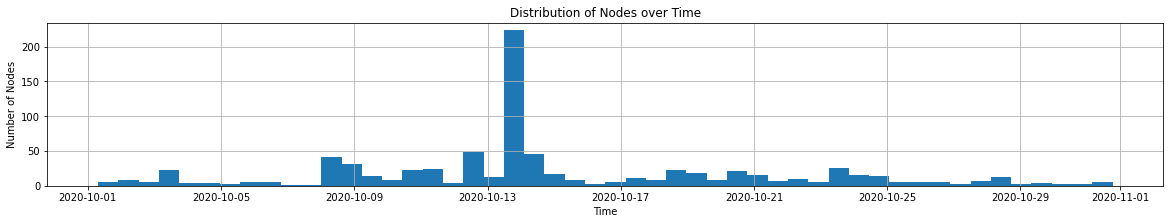

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.057052,#Ingeborgvraagt🍀😇,0.186542,Niels Simons,0.037715,Vester71,0.000416,Karel Tiberius N⭕ ⭕itgedacht,1.0,@StefanTetelepta Ik trek dat zo slecht. Weet j...
1,0.051429,Karel Tiberius N⭕ ⭕itgedacht,0.005105,Tolerance2021 🇳🇱 🌈 ⚽,0.036580,Celal Altuntas,0.000384,#Ingeborgvraagt🍀😇,1.0,@Donderwolkje JA!. Ik ben totaal niet bang aan...
2,0.043996,Vester71,0.003867,Karel Tiberius N⭕ ⭕itgedacht,0.034302,Karel Tiberius N⭕ ⭕itgedacht,0.000376,twopcharts_nl,1.0,@baliekluiver Het is idd. onmogelijk om je alt...
3,0.041497,Celal Altuntas,0.002912,#Ingeborgvraagt🍀😇,0.034162,#Ingeborgvraagt🍀😇,0.000368,Don Roelofsen,1.0,@Topdob11 Ik ben het helemaal met je eens \nLa...
4,0.041130,twopcharts_nl,0.002698,Jan-Luuk,0.033567,Erwin Witteveen,0.000359,Merel Morre,1.0,@Qattekop @janwillemmulder Dat begrijp ik als ...
5,0.040742,Tolerance2021 🇳🇱 🌈 ⚽,0.002407,Erwin Witteveen,0.031539,Peggy BvD,0.000343,Remco,1.0,@CorrieBult @Qattekop Strenger betekent allema...
6,0.040452,Jan-Luuk,0.002232,📸Miss Filter💄🤳🏼,0.028210,📸Miss Filter💄🤳🏼,0.000329,Erwin Witteveen,1.0,"@stefanpostulart Bij ons zitten jaargang 2,3,4..."
7,0.039924,Korreltje zout!,0.002213,Korreltje zout!,0.027776,Richard,0.000326,Koningin Máxima🔸,1.0,RT @19Grafiek: Bij amateursporten gaat het om ...
8,0.038006,Peggy BvD,0.002110,Vester71,0.026736,twopcharts_nl,0.000325,Korreltje zout!,1.0,@tommypijkeren Maar je kunt in de sportschool ...
9,0.034408,Richard,0.001792,Remco,0.025492,Chanarchist 💫,0.000303,Vester71,1.0,@realmpie Toch vreemd dat ik naast wildvreemde...


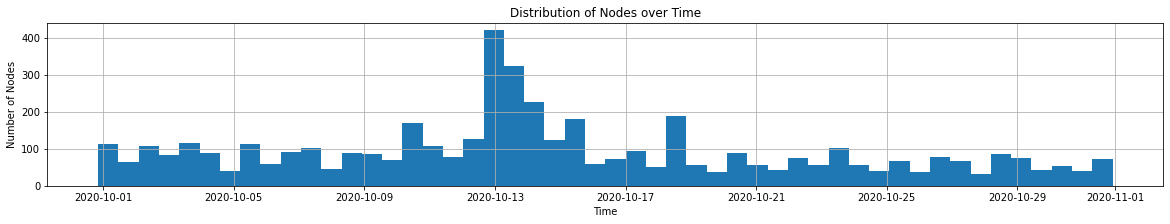

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.075280,Thierry Baudet,0.198059,Maryfloor для России وإيران وسوريا,0.062079,Thierry Baudet,0.001378,Maurice de Hond,1.0,@LeoniqueUnique Ik word wel boos van dat veel ...
1,0.073739,Wierd Duk,0.109384,Hans Zuidinga #Levenskunstenaar,0.056700,Wierd Duk,0.001040,Thierry Baudet,1.0,RT @mauricedehond: Premier Rutte zei gisteren ...
2,0.070701,Maurice de Hond,0.091821,🏛Gaia of the Universe🏛,0.053103,Ebru Umar #1,0.000991,Wybren van Haga,1.0,@VriendinV Maar op de foto ziet het er gezelli...
3,0.056341,Eelco van Hoecke,0.046374,Raisa Blommestijn,0.050931,Maurice de Hond,0.000768,Wierd Duk,1.0,"RT @WybrenvanHaga: De 1,5 meter regel is volko..."
4,0.055663,ZilteHond ☀️,0.041186,Wim Tuijl,0.050725,Sietske Bergsma,0.000598,Fleur Agema,1.0,"RT @WybrenvanHaga: De 1,5 meter regel is volko..."
5,0.053271,Jan Dijkgraaf,0.025933,Jessica,0.050386,Martin Bos,0.000595,Criticaster1960,1.0,RT @mauricedehond: Premier Rutte zei gisteren ...
6,0.051504,Martin Bos,0.015834,Thierry Baudet,0.048908,Jan Dijkgraaf,0.000546,Annelies,1.0,"RT @OBraeckenssieck: Zo kan het helaas gaan,al..."
7,0.051117,blck bx,0.014279,Groninger Hopper,0.048689,ZilteHond ☀️,0.000530,Marianne Zwagerman,1.0,@mind_spin Eerst even de blikken verwerken omd...
8,0.051030,Ebru Umar #1,0.012744,Maurice de Hond,0.048643,Fleur Agema,0.000529,Jan Dijkgraaf,1.0,RT @mauricedehond: Premier Rutte zei gisteren ...
9,0.050298,Lou Lewinsky 2,0.007896,Wybren van Haga,0.048504,John Zuyderduyn,0.000515,Ebru Umar #1,1.0,@RutgerJongejan Dan zijn een mondkapje en 1.5 ...


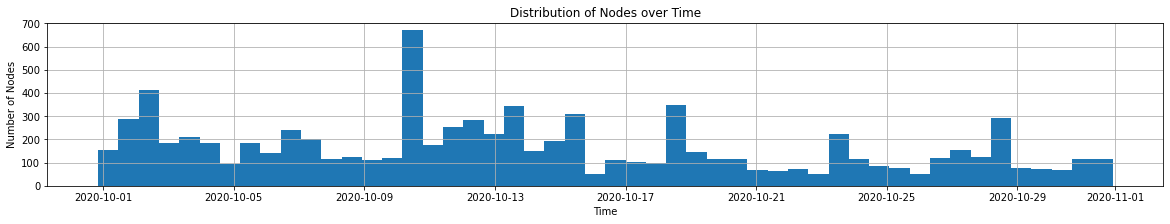

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.123940,NOS,0.037057,NOS,0.053949,NOS,0.002366,Mark Rutte,1.0,"@trouw Heel raar dit, hoezo waren er niet geno..."
1,0.119286,Mark Rutte,0.020467,Mark Rutte,0.050463,Mark Rutte,0.002314,NOS,1.0,RT @sanderschelberg: Het coronavirus is nu ove...
2,0.083069,RIVM,0.014779,RTL Nieuws,0.046476,Saskia Belleman,0.001359,RIVM,1.0,@stefvedder Ik houd mij volledig aan de regels...
3,0.080321,NU.nl,0.013884,De Telegraaf,0.044484,RTL Nieuws,0.001254,NU.nl,1.0,"We gaan het gezellig maken op 1,5 meter van el..."
4,0.076573,de Volkskrant,0.013443,Selmar Smit,0.043964,De Telegraaf,0.001205,Hugo de Jonge,1.0,@dimitri 😄 Maar korte afstanden met veel regen...
5,0.076012,RTL Nieuws,0.012747,NRC,0.042455,Nieuwsuur,0.001155,RTL Nieuws,1.0,@desbarts @NS_online En tbf als afstand houden...
6,0.070055,Nieuwsuur,0.012640,de Volkskrant,0.041637,de Volkskrant,0.001142,De Telegraaf,1.0,RT @Herstelpartner: Even overleggen met verzek...
7,0.069753,Hugo de Jonge,0.011216,RIVM,0.037725,Bas Paternotte,0.000988,de Volkskrant,1.0,RT @Herstelpartner: Even overleggen met verzek...
8,0.067297,De Telegraaf,0.010404,Politie Nederland,0.037688,NU.nl,0.000946,Nieuwsuur,1.0,RT @RTLnieuws: Zonder publiek en met afstand h...
9,0.064636,NRC,0.008057,NU.nl,0.037185,RIVM,0.000928,Ministerie van VWS,1.0,RT @sanderschelberg: Het coronavirus is nu ove...


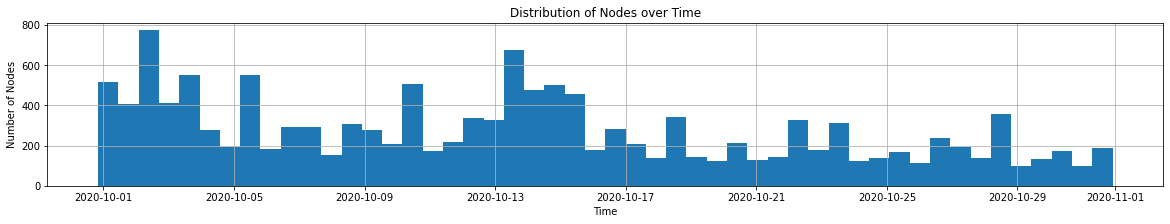

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.082627,Matthijs Pontier 💜🏴‍☠️,0.072585,Y,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001060,Tim Hofman,1.0,RT @gertjansegers: Volgens collega Wilders is ...
1,0.068331,Follow the Money,0.010692,Tim Hofman,0.046740,Follow the Money,0.000839,Sander de Hosson,1.0,"@nikkilykaa Yep, en daarom zijn de ov-ers gewe..."
2,0.059110,Tim Hofman,0.009880,Follow the Money,0.030148,Sander de Hosson,0.000772,Follow the Money,1.0,"RT @HuisartsAlida: Goede voorbeeld van 1,5 met..."
3,0.056729,Sander de Hosson,0.007065,Matthijs Pontier 💜🏴‍☠️,0.029883,Eric Smit,0.000649,Chris Klomp,1.0,RT @Liisalogie: wij op school: ong 5 besmettin...
4,0.055350,Chris Klomp,0.005869,Chris Klomp,0.029515,Eddy Terstall,0.000614,Matthijs Pontier 💜🏴‍☠️,1.0,RT @LotteJensen14: Vandaag! Aujourd'hui! Aange...
5,0.054370,Emine Ugur,0.005864,Sander de Hosson,0.027774,Tim Hofman,0.000550,Partij voor de Dieren,1.0,RT @LotteJensen14: Vandaag! Aujourd'hui! Aange...
6,0.045116,Kirsten Verdel,0.004091,Bert Slagter,0.027612,Kustaw Bessems,0.000545,Bert Slagter,1.0,RT @LotteJensen14: Vandaag! Aujourd'hui! Aange...
7,0.042865,Sander Schimmelpenninck,0.003835,Partij voor de Dieren,0.027128,Anne Fleur Dekker,0.000544,Sander Schimmelpenninck,1.0,@moranazeidekat ze staan hier altijd echt in d...
8,0.042186,Wanda de Kanter,0.003501,Jelmer Visser,0.026546,Chris Klomp,0.000527,Emine Ugur,1.0,@GKleinpaste Afstand houden tot elkaar lukt bl...
9,0.041637,Marion Koopmans,0.003029,Lisa Westerveld,0.025146,Hoofdzuster,0.000523,Marion Koopmans,1.0,RT @ReintJanRenes: Verdiepende analyse van de ...


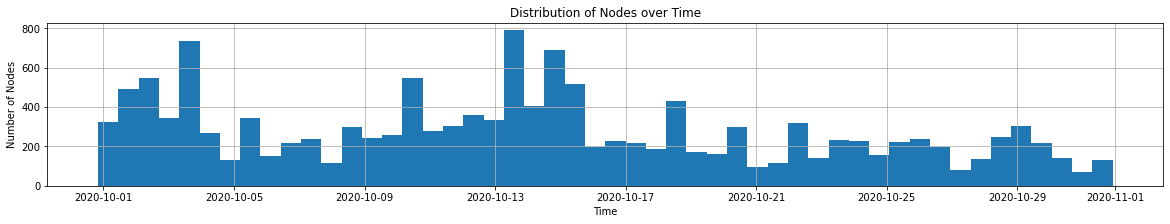

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.062083,Marc Van Ranst,0.014766,Marc Van Ranst,0.026142,ockhams-scheermes,0.001283,Marc Van Ranst,1.0,@fransmaes1 Ik hou in ieder geval een veilige ...
1,0.025822,ockhams-scheermes,0.005697,Fouad Gandoul,0.021568,Lambrechts Emiel,0.000821,Fouad Gandoul,1.0,RT @Fgandoul: Dan hou je je als restauranthoud...
2,0.021750,Joël De Ceulaer,0.004829,Knack,0.021256,Vincent,0.000414,HLN.BE,1.0,"@jdceulaer fijn. nu, spaghetti op vrijdag is, ..."
3,0.021502,K. Le Bato,0.004261,HLN.BE,0.020357,Marc Van Ranst,0.000318,Joël De Ceulaer,1.0,"@jdceulaer Jeetje 😱, werkend in de ambulante z..."
4,0.021405,HLN.BE,0.003311,Nieuwsblad.be,0.018291,misterdoom,0.000310,De Morgen,1.0,@gillesDM92 Hij heeft hier wel een punt. Niet ...
5,0.020985,N-VA,0.002408,Armand Vervaeck🎗️,0.016545,Maria Vanlommel,0.000278,CrisisCenter Belgium,1.0,@is_veel Ik knuffel enkel mijn kleinzoon...van...
6,0.020684,Arbiter,0.002230,Arbiter,0.015509,Erik De Wilde,0.000278,Sammy Mahdi,1.0,"@philippe_wartel Nee, daar zit geen nuance in...."
7,0.020059,De Morgen,0.002148,N-VA,0.014900,Armand Vervaeck🎗️,0.000270,Arbiter,1.0,Dan hou je je als restauranthouder aan alle re...
8,0.019790,Vincent,0.001605,HBvL,0.014765,K. Le Bato,0.000269,sporza,1.0,RT @Fgandoul: Dan hou je je als restauranthoud...
9,0.019693,Armand Vervaeck🎗️,0.001604,De Morgen,0.014666,Assita Kanko MEP,0.000262,Knack,1.0,RT @Fgandoul: Dan hou je je als restauranthoud...


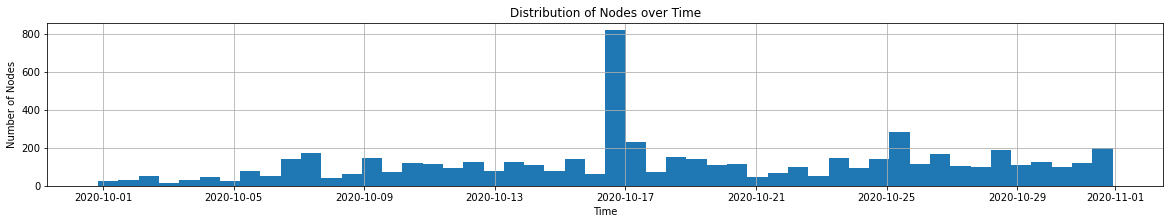

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.3903508307960546
Number of communities: 688


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

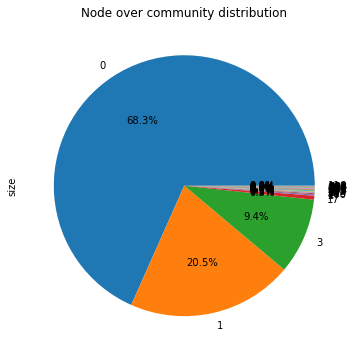

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.123940,NOS,0.186542,Niels Simons,0.056700,Wierd Duk,0.002366,Mark Rutte,1.0,@MrX1289 Mondkapje om en afstand houden. Dat d...
1,0.119286,Mark Rutte,0.072585,Y,0.053949,NOS,0.002314,NOS,1.0,@loekraaij Ik ben niet overtuigd dat dit verst...
2,0.083069,RIVM,0.046374,Raisa Blommestijn,0.050931,Maurice de Hond,0.001378,Maurice de Hond,1.0,Hoor net iemand @NPORadio1 met een wijntje in ...
3,0.082627,Matthijs Pontier 💜🏴‍☠️,0.037057,NOS,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001359,RIVM,1.0,@margaijz Teveel om in een tweet kwijt te kunn...
4,0.080321,NU.nl,0.020467,Mark Rutte,0.050463,Mark Rutte,0.001283,Marc Van Ranst,1.0,"@Dinsdal85174312 Wel op anderhalve meter, hoop..."
5,0.076573,de Volkskrant,0.014779,RTL Nieuws,0.046740,Follow the Money,0.001254,NU.nl,1.0,RT @MinBZK: Dringend advies: draag vanaf vanda...
6,0.076012,RTL Nieuws,0.014766,Marc Van Ranst,0.046476,Saskia Belleman,0.001205,Hugo de Jonge,1.0,@loekraaij Ook blijft overeind dat die maskers...
7,0.073739,Wierd Duk,0.013884,De Telegraaf,0.044484,RTL Nieuws,0.001155,RTL Nieuws,1.0,RT @MinVWS: Dringend advies: draag vanaf vanda...
8,0.070701,Maurice de Hond,0.013443,Selmar Smit,0.043964,De Telegraaf,0.001142,De Telegraaf,1.0,RT @MinVWS: Dringend advies: draag vanaf vanda...
9,0.070055,Nieuwsuur,0.012747,NRC,0.042455,Nieuwsuur,0.001060,Tim Hofman,1.0,RT @ContainmentNu: De zorg staat op klappen. \...


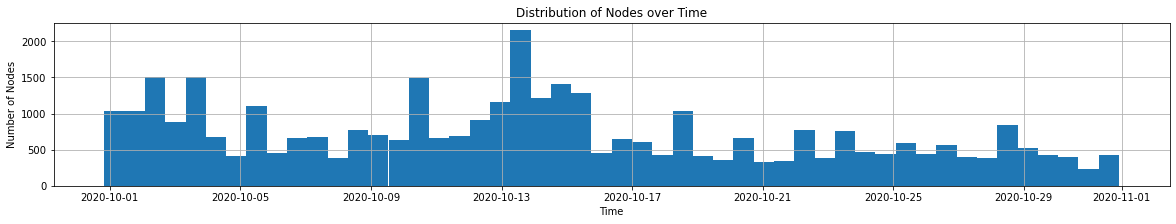

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.075280,Thierry Baudet,0.198059,Maryfloor для России وإيران وسوريا,0.062079,Thierry Baudet,0.001040,Thierry Baudet,1.0,@LeoniqueUnique Ik word wel boos van dat veel ...
1,0.056341,Eelco van Hoecke,0.109384,Hans Zuidinga #Levenskunstenaar,0.053103,Ebru Umar #1,0.000991,Wybren van Haga,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
2,0.055663,ZilteHond ☀️,0.091821,🏛Gaia of the Universe🏛,0.050725,Sietske Bergsma,0.000598,Fleur Agema,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
3,0.053271,Jan Dijkgraaf,0.041186,Wim Tuijl,0.050386,Martin Bos,0.000595,Criticaster1960,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
4,0.051504,Martin Bos,0.025933,Jessica,0.048908,Jan Dijkgraaf,0.000546,Annelies,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
5,0.051117,blck bx,0.015834,Thierry Baudet,0.048689,ZilteHond ☀️,0.000530,Marianne Zwagerman,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
6,0.051030,Ebru Umar #1,0.014279,Groninger Hopper,0.048643,Fleur Agema,0.000529,Jan Dijkgraaf,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
7,0.050298,Lou Lewinsky 2,0.007896,Wybren van Haga,0.048504,John Zuyderduyn,0.000515,Ebru Umar #1,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
8,0.049975,Wybren van Haga,0.006620,Fleur Agema,0.048324,FvD lid 🚜,0.000488,Sietske Bergsma,1.0,RT @AsbaiBadr: Strengere maatregelen= staat vo...
9,0.048854,John Zuyderduyn,0.005341,Annelies,0.048258,Roel du Pree,0.000466,blck bx,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...


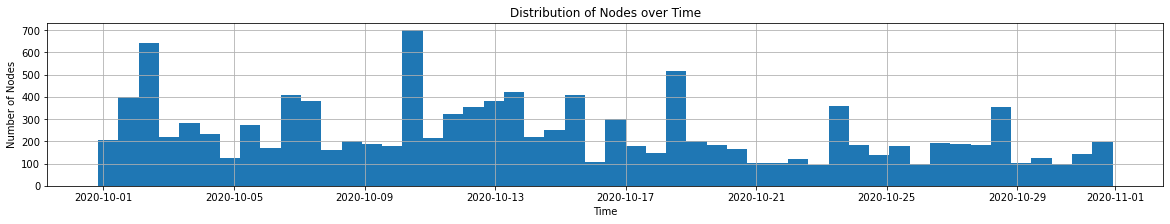

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001023,ᴮᴱNikita⁷ maskertje op,0.000322,ᴮᴱNikita⁷ maskertje op,0.000558,ᴮᴱNikita⁷ maskertje op,0.000070,M⁷☆,1.0,"@sandaengi Ooh, en ik zie ook al goede 1.5m en..."
1,0.000980,M⁷☆,0.000192,♡𝑺𝒖𝒅𝒆 𝒁𝒂𝒏𝒂🐺⁷/ BLM ACAB FREE🇵🇸,0.000361,🖤ᴸᶦᵉˢʲᵉ,0.000054,ᴮᴱNikita⁷ maskertje op,1.0,@bammiesflower Ja laten we kijken of ie nog wa...
2,0.000679,☆ annieʲᵏ,0.000121,M⁷☆,0.000216,Charlotte⁷,0.000040,hanna,1.0,RT @debroervanroos: wacht. jongeren tot 18 jaa...
3,0.000679,hanna,0.000085,𝘪𝘭𝘰𝘯𝘢🧸♡ minho,0.000194,Sterre,0.000037,Charlotte⁷,1.0,RT @debroervanroos: wacht. jongeren tot 18 jaa...
4,0.000625,Charlotte⁷,0.000074,🖤ᴸᶦᵉˢʲᵉ,0.000153,enya🍂🃏BLM,0.000035,☆ annieʲᵏ,1.0,RT @debroervanroos: wacht. jongeren tot 18 jaa...
5,0.000614,ᴮᴱnienke⁷,0.000072,Charlotte⁷,0.000151,"bIm | hello, essan⚔️🐍",0.000034,Hadia⁷,1.0,Nora/kaz00mi
6,0.000614,Hadia⁷,0.000070,Lachimolala⁷,0.000142,Lachimolala⁷,0.000032,JJK⁷ 🗃️🧮,1.0,RT @debroervanroos: wacht. jongeren tot 18 jaa...
7,0.000582,ᴮᴱ rach⁷,0.000065,hanna,0.000141,sulky⁷,0.000031,ᴮᴱnienke⁷,1.0,@lilchaengie ik hoor d3ze queen ecgt al voor d...
8,0.000539,JJK⁷ 🗃️🧮,0.000048,𝐷𝑎𝑛𝑎 ㋛,0.000118,ᴮᴱnienke⁷,0.000030,♥Brave⁷.•,1.0,RT @moonieminjoonie: Deze foto's zijn vandaag ...
9,0.000485,𝐷𝑎𝑛𝑎 ㋛,0.000042,"bIm | hello, essan⚔️🐍",0.000107,\⁷ rereading ACOTAR| IREE DAY,0.000030,♡𝑺𝒖𝒅𝒆 𝒁𝒂𝒏𝒂🐺⁷/ BLM ACAB FREE🇵🇸,1.0,RT @moonieminjoonie: Deze foto's zijn vandaag ...


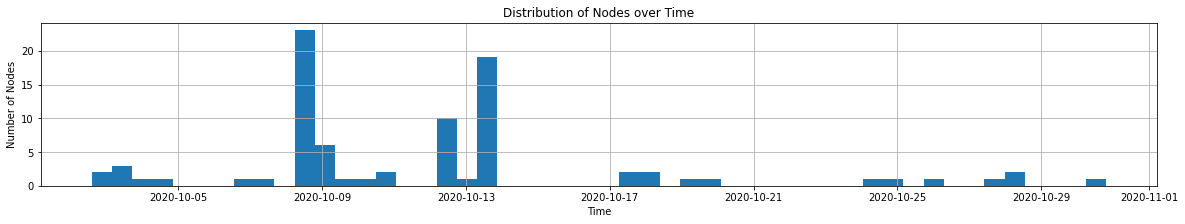

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.021750,Joël De Ceulaer,0.005697,Fouad Gandoul,0.012343,HLN.BE,0.000821,Fouad Gandoul,1.0,@KrisRemels Logisch toch? De 6 gouden regels:...
1,0.021405,HLN.BE,0.004829,Knack,0.009153,steven vermeylen,0.000414,HLN.BE,1.0,@lorebriersx Als het officieel niet zou mogen ...
2,0.020985,N-VA,0.004261,HLN.BE,0.008596,De Morgen,0.000318,Joël De Ceulaer,1.0,RT @SammyMahdi: Houden ons aan de regels zoals...
3,0.020684,Arbiter,0.003311,Nieuwsblad.be,0.008590,Knack,0.000310,De Morgen,1.0,@ChristiaanCV @SammyMahdi Denk je nu dat die i...
4,0.020059,De Morgen,0.002230,Arbiter,0.008522,N-VA,0.000278,CrisisCenter Belgium,1.0,@HardwerkendeVL Gelukkig houden ze afstand. De...
5,0.019175,Knack,0.002148,N-VA,0.007929,Karl Drabbe 🎗,0.000278,Sammy Mahdi,1.0,@stevenarents Anderhalve meter blijkt een moei...
6,0.016461,CrisisCenter Belgium,0.001605,HBvL,0.007913,Dirk Verhofstadt,0.000270,Arbiter,1.0,@biekepurnelle @SammyMahdi Ik vind dit echt on...
7,0.016245,bart eeckhout,0.001604,De Morgen,0.007313,Dyab Abou Jahjah,0.000269,sporza,1.0,RT @SaidBataray: Telewerk is sinds maart sterk...
8,0.016008,Jan Jambon,0.001573,Sammy Mahdi,0.007305,Inge NWN®™‏,0.000262,Knack,1.0,@timcorbeel Bij ons op kantoor waren er indivi...
9,0.015836,Radio 1,0.001470,humo,0.006650,башлам,0.000262,zin om je tom helsen,1.0,Zoals @AK_1983_ zegt: \n\nTer info: telewerk w...


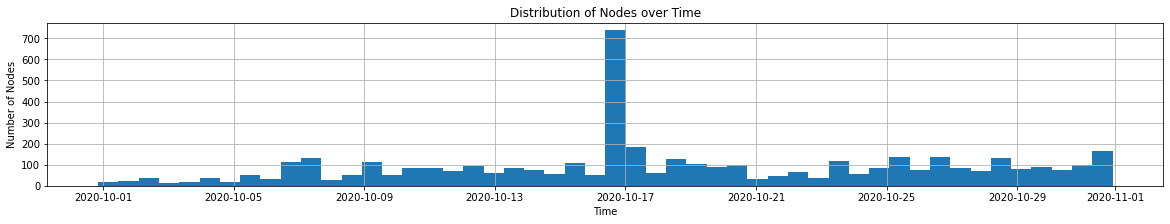

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000032,Azazel🍂,0.000011,Azazel🍂,3.606676e-07,Azazel🍂,0.000006,Azazel🍂,0.0,Azazel🍂
1,0.000022,en als wij nog beter moeten opletten denk miss...,0.000000,en als wij nog beter moeten opletten denk miss...,4.981075e-10,en als wij nog beter moeten opletten denk miss...,0.000005,en als wij nog beter moeten opletten denk miss...,NaN,en als wij nog beter moeten opletten denk miss...


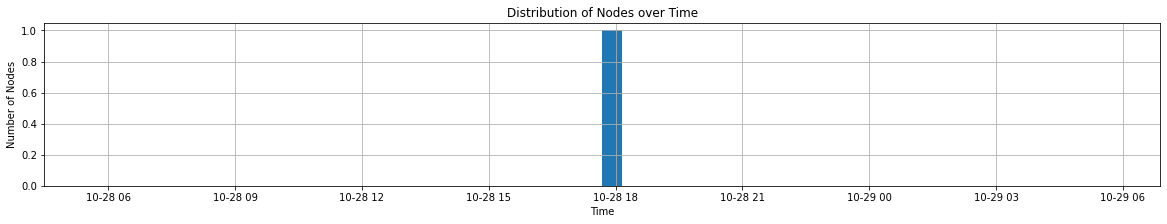

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001390,Sven Groter_3,0.000358,Sven Groter_3,0.000055,RT @HansDek35828687: Ondertussen: demonstratie...,0.000141,Sven Groter_3,0.166667,@3Groter @Fleur_Ru11 #BAL Bewust Afstandhouden...
1,0.000162,ARTSEN,0.000051,@3Groter @JDreport ze gaan steeds een stapje v...,0.000041,RT @3Groter: Arts was -terecht- (zoals zovele ...,0.000017,ARTSEN,0.000305,Sven Groter_3
2,0.000162,TISJEBOYJAY,0.000030,"RT @3Groter: Avondklok pure nonsens, volk word...",0.000038,@3Groter @Fleur_Ru11 #BAL Bewust Afstandhouden...,0.000017,TISJEBOYJAY,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
3,0.000108,tegen,0.000013,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000037,"RT @3Groter: Avondklok pure nonsens, volk word...",0.000012,tegen,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
4,0.000054,@3Groter @Fleur_Ru11 #BAL Bewust Afstandhouden...,0.000013,RT @3Groter: Arts was -terecht- (zoals zovele ...,0.000033,RT @3Groter: Arts was -terecht- (zoals zovele ...,0.000011,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
5,0.000043,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000013,@3Groter @Fleur_Ru11 #BAL Bewust Afstandhouden...,0.000033,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000010,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
6,0.000043,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000012,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000030,@3Groter @JDreport ze gaan steeds een stapje v...,0.000010,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
7,0.000043,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000011,RT @HansDek35828687: Ondertussen: demonstratie...,0.000029,"RT @3Groter: Avondklok pure nonsens, volk word...",0.000010,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
8,0.000043,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000011,"@3Groter Dat herken ik wel ja, aankijken met...",0.000027,RT @3Groter: Arts was -terecht- (zoals zovele ...,0.000010,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."
9,0.000043,RT @3Groter: https://t.co/q1nz6QpSjy\n\n#TISJE...,0.000011,https://t.co/fsmGfqEkyX\n\nMenszijn is het #TE...,0.000025,RT @3Groter: Arts was -terecht- (zoals zovele ...,0.000009,https://t.co/fsmGfqEkyX\n\nMenszijn is het #TE...,0.000000,"RT @3Groter: Avondklok pure nonsens, volk word..."


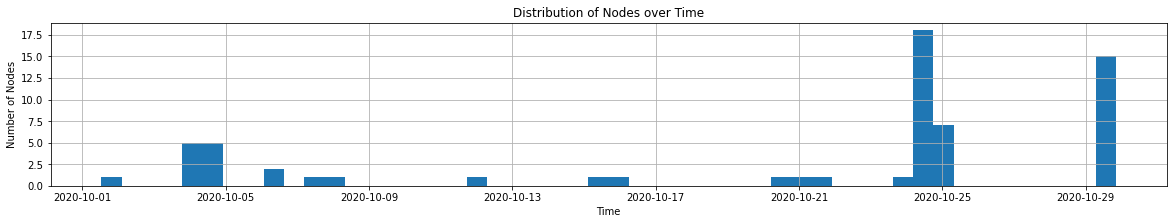

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')